<a href="https://colab.research.google.com/github/StephenSheng1101/DMAsgmnt/blob/main/Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ridge Regression**


**Data Preprocessing before begin with Ridge Regression**

In [12]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [13]:
df = pd.read_csv("dataset.csv")

In [14]:
def load_transport_data():
    tarball_path = Path("/content/dataset.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        with tarfile.open(tarball_path) as transport_tarball:
            transport_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/content/dataset.csv"))

transport = load_transport_data()
transport.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,2013-07-02 19:54:00.000000232,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1
1,2013-09-28 00:21:31.0000002,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1
2,2013-06-16 03:18:00.000000150,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1
3,2013-07-20 13:43:00.000000121,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5
4,2013-11-05 22:57:17.0000003,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2


In [15]:
transport.describe()
transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596558 entries, 0 to 2596557
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ID              object 
 1   travel_fee      float64
 2   departure_time  object 
 3   departure_long  float64
 4   departure_lat   float64
 5   arrival_long    float64
 6   arrival_lat     float64
 7   occupancy       int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 158.5+ MB


In [16]:
transport.isnull().sum()

ID                 0
travel_fee         0
departure_time     0
departure_long     0
departure_lat      0
arrival_long      44
arrival_lat       44
occupancy          0
dtype: int64

In [17]:
#handling missing value
transport["departure_long"].fillna(transport["departure_long"].mean(), inplace=True)
transport["departure_lat"].fillna(transport["departure_lat"].mean(), inplace=True)
transport["occupancy"].fillna(transport["occupancy"].mode()[0], inplace=True)
transport.drop(columns=['ID'], inplace=True)

# Drop rows with missing "departure_time","arrival_long" and "arrival_lat"
transport.dropna(subset=["departure_time", "arrival_long", "arrival_lat"],inplace = True)
transport.isnull().sum()

# Drop rows with a 0 value of occupancy
transport = transport.drop(transport[transport['occupancy'] <= 0].index)

In [18]:
transport.head()

,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1
1,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1
2,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1
3,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5
4,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2


In [19]:
# Convert departure_time to datetime
transport['departure_time'] = pd.to_datetime(transport['departure_time'])

# Extract features from departure_time
transport['hour_of_day'] = transport['departure_time'].dt.hour
transport['day_of_week'] = transport['departure_time'].dt.dayofweek

In [20]:
from sklearn.preprocessing import StandardScaler

data_numeric = transport.drop(columns=['departure_time'])

# Perform feature scaling using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_numeric)
scaled_data

array([[-0.51734933, -0.13933522,  0.10789769, ..., -0.51574494,
         0.83932454, -1.04160923],
       [-0.65604557, -0.14011792,  0.10571586, ..., -0.51574494,
        -2.06546508,  1.00306776],
       [ 0.823381  , -0.13806539,  0.11134518, ..., -0.51574494,
        -1.60681409,  1.51423701],
       ...,
       [ 2.65694529, -0.12666484,  0.11228498, ...,  0.21130803,
         0.07490622,  1.00306776],
       [-0.47111725, -0.13623989,  0.11150011, ..., -0.51574494,
         0.99220821,  1.51423701],
       [-0.47111725, -0.13712509,  0.11297623, ..., -0.51574494,
         0.68644088, -0.53043998]])

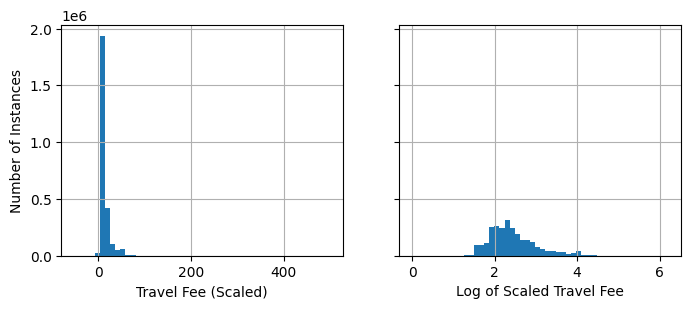

In [21]:
# Plot histogram of a scaled feature
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
transport["travel_fee"].hist(ax=axs[0], bins=50)
transport["travel_fee"].apply(np.log1p).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Travel Fee (Scaled)")
axs[1].set_xlabel("Log of Scaled Travel Fee")
axs[0].set_ylabel("Number of Instances")
plt.show()

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ['travel_fee', 'departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'hour_of_day', 'day_of_week','occupancy']

num_pipeline = make_pipeline(
    StandardScaler()  # Scale features
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    # Apply numeric pipeline to numeric attributes
])

In [23]:
transport_prepared = preprocessing.fit_transform(transport)
transport_prepared

array([[-0.51734933, -0.13933522,  0.10789769, ...,  0.83932454,
        -1.04160923, -0.51574494],
       [-0.65604557, -0.14011792,  0.10571586, ..., -2.06546508,
         1.00306776, -0.51574494],
       [ 0.823381  , -0.13806539,  0.11134518, ..., -1.60681409,
         1.51423701, -0.51574494],
       ...,
       [ 2.65694529, -0.12666484,  0.11228498, ...,  0.07490622,
         1.00306776,  0.21130803],
       [-0.47111725, -0.13623989,  0.11150011, ...,  0.99220821,
         1.51423701, -0.51574494],
       [-0.47111725, -0.13712509,  0.11297623, ...,  0.68644088,
        -0.53043998, -0.51574494]])

**Select and Train a Model on the Prepared Training Set**

**Ridge Regression**

Ridge Regression is a regularization technique used to prevent overfitting in linear regression models by adding a penalty term to the cost function based on the L2 norm of the coefficients. Let's continue with implementing Ridge Regression the preprocessed data.

In [24]:
#Imported necessary libraries and modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics.pairwise import euclidean_distances

In [25]:
# Define features (X) and target variable (y)
X = transport_prepared[:, 1:]  # Exclude the 'travel_fee' column
y = transport_prepared[:, 0]   # Use the 'travel_fee' column as the target variable


In [26]:
# Define different alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [27]:
# Create an empty dictionary to store RMSE scores for each alpha
rmse_scores_dict = {}

In [28]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# Iterate through each alpha value
for alpha in alphas:
    # Create a Ridge Regression model with the current alpha
    model = Ridge(alpha=alpha)

    # Perform K-fold cross-validation
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error'))

    # Store the RMSE scores in the dictionary
    rmse_scores_dict[alpha] = rmse_scores

In [30]:
# Convert the dictionary into a DataFrame for easier analysis
rmse_df = pd.DataFrame(rmse_scores_dict)

In [31]:
# Calculate the mean RMSE and standard deviation for each alpha
rmse_mean = rmse_df.mean()
rmse_std = rmse_df.std()

In [32]:
# Find the alpha with the lowest mean RMSE
best_alpha = rmse_mean.idxmin()

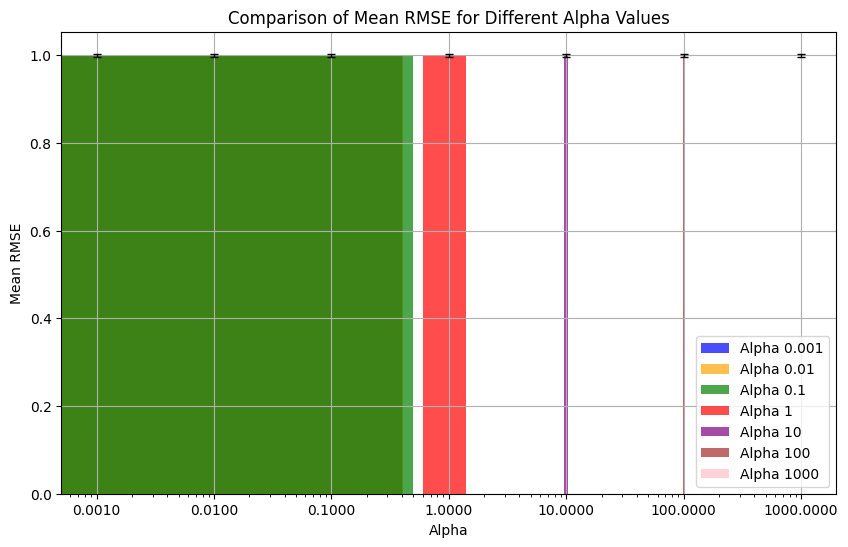

Mean RMSE for each alpha:
0.0010000000: 0.9995258705
0.0100000000: 0.9995258705
0.1000000000: 0.9995258705
1.0000000000: 0.9995258700
10.0000000000: 0.9995258656
100.0000000000: 0.9995258215
1000.0000000000: 0.9995253917

Standard Deviation of RMSE for each alpha:
0.0010000000: 0.0040484619
0.0100000000: 0.0040484619
0.1000000000: 0.0040484619
1.0000000000: 0.0040484614
10.0000000000: 0.0040484569
100.0000000000: 0.0040484113
1000.0000000000: 0.0040479650

Best alpha: 1000.0


In [43]:
# Define colors for each bar
bar_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

# Visualize the comparison between each alpha outcome using a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(alphas, rmse_mean, yerr=rmse_std, align='center', capsize=5, color=bar_colors, alpha=0.7, error_kw={'elinewidth': 1, 'capsize': 3})
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Alpha')
plt.ylabel('Mean RMSE')
plt.title('Comparison of Mean RMSE for Different Alpha Values')
plt.xticks(alphas, ['{:.4f}'.format(a) for a in alphas])  # Set x-axis ticks to the specified alpha values
plt.grid(True)
plt.legend(bars, ['Alpha ' + str(a) for a in alphas])  # Add legend
plt.show()

print("Mean RMSE for each alpha:")
for alpha, mean_rmse in zip(alphas, rmse_mean):
    print("{:.10f}: {:.10f}".format(alpha, mean_rmse))

print("\nStandard Deviation of RMSE for each alpha:")
for alpha, std_rmse in zip(alphas, rmse_std):
    print("{:.10f}: {:.10f}".format(alpha, std_rmse))

print("\nBest alpha:", best_alpha)